In [55]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


sklearn version:  1.2.0
TF version:  2.10.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [56]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Add,  Dense, Conv2D, Activation
from keras.models import Sequential

In [57]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [58]:
import csv
def load_Emist():
    X_train=np.load('X_train.npy')
    y_train=np.load('y_train.npy')
    X_valid=np.load('X_valid.npy')
    y_valid=np.load('y_valid.npy')
    return X_train, y_train, X_valid, y_valid


In [59]:
X_train, y_train, X_valid, y_valid = load_Emist()
X_train.shape,X_train.dtype

((533917, 28, 28), dtype('uint8'))

In [60]:
#data, batch size 성정
train_size=len(X_train)
valid_size=len(X_valid)
batch_size=32

In [61]:
X_train=np.reshape(X_train,[-1,784])
X_valid=np.reshape(X_valid,[-1,784])

In [62]:
y_train=np.reshape(y_train,[-1,1])
y_valid=np.reshape(y_valid,[-1,1])

In [63]:
train_full = np.append(X_train,y_train,axis=1)
valid_full = np.append(X_valid,y_valid,axis=1)

In [64]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:03d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [65]:
train_filepaths = save_to_multiple_csv_files(train_full, "train")
valid_filepaths = save_to_multiple_csv_files(valid_full, "valid")

In [66]:
n_inputs = X_train.shape[-1]
def preprocess_make(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    resized_image = x
    final_image = resized_image/255.
    return final_image, y

In [67]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess_make, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [68]:
train_set = csv_reader_dataset(train_filepaths,batch_size=batch_size, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths,batch_size=batch_size, repeat=None)

In [70]:
K = keras.backend
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

# OneCycleScheduler

In [71]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [69]:
early_stopping_BRN50 = EarlyStopping(patience = 10)
data_name="byclass" 
type_name="make"
hypara="adam"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [72]:
n_epochs = 24
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,onecycle])

Epoch 1/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.7652 - accuracy: 0.7705
Epoch 1: val_loss improved from inf to 0.52115, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 274s 16ms/step - loss: 0.7652 - accuracy: 0.7705 - val_loss: 0.5211 - val_accuracy: 0.8333
Epoch 2/1000
16684/16684 [==============================] - ETA: 0s - loss: 0.8752 - accuracy: 0.7679
Epoch 2: val_loss did not improve from 0.52115
16684/16684 [==============================] - 271s 16ms/step - loss: 0.8752 - accuracy: 0.7679 - val_loss: 0.8854 - val_accuracy: 0.8140
Epoch 3/1000
16681/16684 [============================>.] - ETA: 0s - loss: 1.1750 - accuracy: 0.7440
Epoch 3: val_loss did not improve from 0.52115
16684/16684 [==============================] - 270s 16ms/step - loss: 1.1750 - accuracy: 0.7440 - val_loss: 0.9400 - val_accuracy: 0.8088
Epoch 4/1000
16682/16684 [============================>.] - ETA: 0s - loss: 1.6123 - accuracy: 0.7307

<AxesSubplot: >

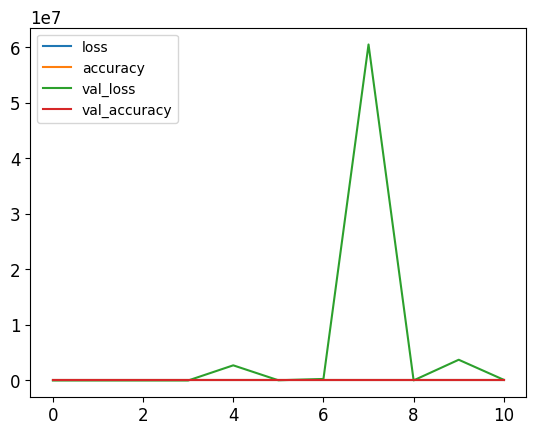

In [73]:
pd.DataFrame(history.history).plot()

### lr설정에 문제가  있어서 이런 이상한 그래프가 등장하였다.

# Ir 수정

In [ ]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [ ]:
early_stopping_BRN50 = EarlyStopping(patience = 10)
data_name="byclass" 
type_name="make"
hypara="one_cy_re"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [24]:
n_epochs = 24
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,onecycle])

Epoch 1/1000
16677/16684 [============================>.] - ETA: 0s - loss: 0.6569 - accuracy: 0.7894
Epoch 1: val_loss improved from inf to 0.40532, saving model to byclass_make_one_cy_re.h5
16684/16684 [==============================] - 115s 7ms/step - loss: 0.6567 - accuracy: 0.7894 - val_loss: 0.4053 - val_accuracy: 0.8534
Epoch 2/1000
16681/16684 [============================>.] - ETA: 0s - loss: 0.4726 - accuracy: 0.8346
Epoch 2: val_loss improved from 0.40532 to 0.39891, saving model to byclass_make_one_cy_re.h5
16684/16684 [==============================] - 115s 7ms/step - loss: 0.4726 - accuracy: 0.8346 - val_loss: 0.3989 - val_accuracy: 0.8554
Epoch 3/1000
16677/16684 [============================>.] - ETA: 0s - loss: 0.4409 - accuracy: 0.8435
Epoch 3: val_loss improved from 0.39891 to 0.38441, saving model to byclass_make_one_cy_re.h5
16684/16684 [==============================] - 115s 7ms/step - loss: 0.4409 - accuracy: 0.8435 - val_loss: 0.3844 - val_accuracy: 0.8600
Epoch

<AxesSubplot: >

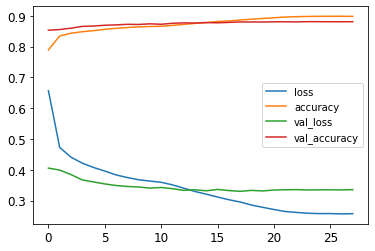

In [25]:
pd.DataFrame(history.history).plot()

# Exponential_decay scheduler

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

In [ ]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [ ]:
early_stopping_BRN50 = EarlyStopping(patience = 5)
data_name="byclass" 
type_name="make"
hypara="adam"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr_scheduler])

In [22]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr_scheduler])

Epoch 1/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.9148 - accuracy: 0.7419
Epoch 1: val_loss improved from inf to 4.72746, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 243s 14ms/step - loss: 0.9148 - accuracy: 0.7419 - val_loss: 4.7275 - val_accuracy: 0.8166 - lr: 0.0100
Epoch 2/1000
16681/16684 [============================>.] - ETA: 0s - loss: 0.7494 - accuracy: 0.7765
Epoch 2: val_loss did not improve from 4.72746
16684/16684 [==============================] - 241s 14ms/step - loss: 0.7494 - accuracy: 0.7765 - val_loss: 289.5843 - val_accuracy: 0.8252 - lr: 0.0089
Epoch 3/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.6656 - accuracy: 0.7926
Epoch 3: val_loss did not improve from 4.72746
16684/16684 [==============================] - 241s 14ms/step - loss: 0.6656 - accuracy: 0.7926 - val_loss: 33.6938 - val_accuracy: 0.8333 - lr: 0.0079
Epoch 4/1000
16680/16684 [============================>.] -

<AxesSubplot: >

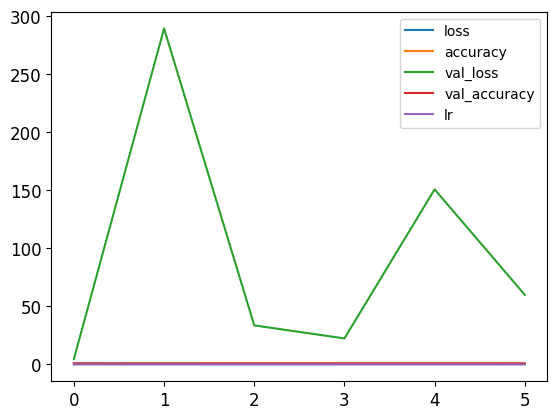

In [23]:
pd.DataFrame(history.history).plot()

### lr설정에 문제가 있어서 이런 이상한 그래프가 등장하였다

# Ir 수정

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

In [ ]:
exponential_decay_fn = exponential_decay(lr0=0.001, s=20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [ ]:
early_stopping_BRN50 = EarlyStopping(patience = 5)
data_name="byclass" 
type_name="make"
hypara="exp_re"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [27]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr_scheduler])

Epoch 1/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.6216 - accuracy: 0.7982
Epoch 1: val_loss improved from inf to 0.40822, saving model to byclass_make_exp_re.h5
16684/16684 [==============================] - 240s 14ms/step - loss: 0.6216 - accuracy: 0.7982 - val_loss: 0.4082 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/1000
16682/16684 [============================>.] - ETA: 0s - loss: 0.4380 - accuracy: 0.8441
Epoch 2: val_loss improved from 0.40822 to 0.36608, saving model to byclass_make_exp_re.h5
16684/16684 [==============================] - 318s 19ms/step - loss: 0.4379 - accuracy: 0.8441 - val_loss: 0.3661 - val_accuracy: 0.8635 - lr: 8.9125e-04
Epoch 3/1000
16681/16684 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8559
Epoch 3: val_loss improved from 0.36608 to 0.35134, saving model to byclass_make_exp_re.h5
16684/16684 [==============================] - 316s 19ms/step - loss: 0.3989 - accuracy: 0.8559 - val_loss: 0.3513 - va

<AxesSubplot: >

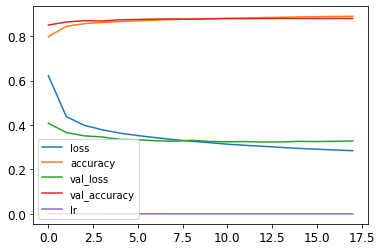

In [28]:
pd.DataFrame(history.history).plot()

# s값 수정

In [ ]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [ ]:
exponential_decay_fn = exponential_decay(lr0=0.001, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
early_stopping_BRN50 = EarlyStopping(patience = 5)
data_name="byclass" 
type_name="make"
hypara="exp_re_ver2"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [24]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr_scheduler])

Epoch 1/1000
16682/16684 [============================>.] - ETA: 0s - loss: 0.6068 - accuracy: 0.8011
Epoch 1: val_loss improved from inf to 0.40368, saving model to byclass_make_exp_re_ver2.h5
16684/16684 [==============================] - 315s 19ms/step - loss: 0.6068 - accuracy: 0.8011 - val_loss: 0.4037 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 2/1000
16684/16684 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.8449
Epoch 2: val_loss improved from 0.40368 to 0.36533, saving model to byclass_make_exp_re_ver2.h5
16684/16684 [==============================] - 317s 19ms/step - loss: 0.4354 - accuracy: 0.8449 - val_loss: 0.3653 - val_accuracy: 0.8639 - lr: 7.9433e-04
Epoch 3/1000
16683/16684 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8568
Epoch 3: val_loss improved from 0.36533 to 0.34971, saving model to byclass_make_exp_re_ver2.h5
16684/16684 [==============================] - 314s 19ms/step - loss: 0.3962 - accuracy: 0.8568 - val_lo

<AxesSubplot: >

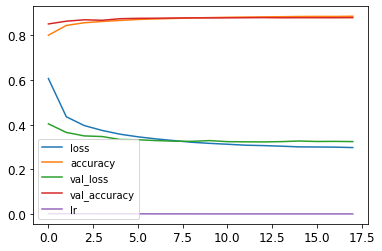

In [25]:
pd.DataFrame(history.history).plot()

#  Piecewise schedule

In [ ]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
early_stopping_BRN50 = EarlyStopping(patience = 10)
data_name="byclass" 
type_name="make"
hypara="adam"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [19]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr_scheduler])

Epoch 1/1000
16682/16684 [============================>.] - ETA: 0s - loss: 0.8784 - accuracy: 0.7519
Epoch 1: val_loss improved from inf to 0.64733, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 328s 19ms/step - loss: 0.8784 - accuracy: 0.7519 - val_loss: 0.6473 - val_accuracy: 0.8135 - lr: 0.0100
Epoch 2/1000
16682/16684 [============================>.] - ETA: 0s - loss: 0.7822 - accuracy: 0.7776
Epoch 2: val_loss improved from 0.64733 to 0.57068, saving model to byclass_make_adam.h5
16684/16684 [==============================] - 247s 15ms/step - loss: 0.7822 - accuracy: 0.7776 - val_loss: 0.5707 - val_accuracy: 0.8300 - lr: 0.0100
Epoch 3/1000
16684/16684 [==============================] - ETA: 0s - loss: 0.7543 - accuracy: 0.7842
Epoch 3: val_loss did not improve from 0.57068
16684/16684 [==============================] - 244s 15ms/step - loss: 0.7543 - accuracy: 0.7842 - val_loss: 1.1182 - val_accuracy: 0.8331 - lr: 0.0100
Epoch 4/1000
16682/1

<AxesSubplot: >

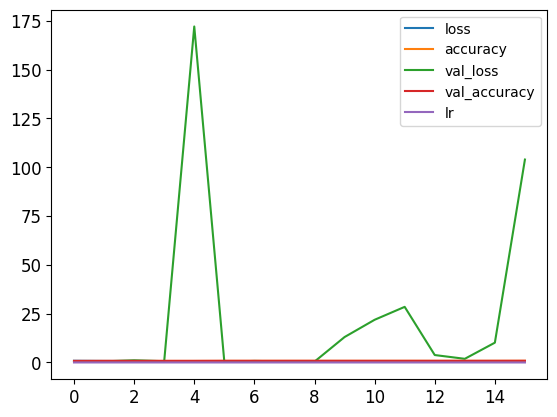

In [20]:
pd.DataFrame(history.history).plot()

### 잘못된 Ir  설정으로 문제 발생

# Ir 구간  & 값 변경

In [ ]:
model = Sequential()
model.add(Conv2D(32, 5, padding='same', activation='relu', input_shape=[28,28,1]))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, 2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5,10, 15], [0.001, 0.0005, 0.0003, 0.00005])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

In [ ]:
early_stopping_BRN50 = EarlyStopping(patience = 10)
data_name="byclass" 
type_name="make"
hypara="adam_piecewise"
optimizer=tf.keras.optimizers.Adam()
checkpoint_callback_BRN50 = ModelCheckpoint(data_name+"_"+type_name+"_"+hypara+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [19]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'],)
history=model.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size), 
                    epochs=1000,
                    callbacks=[early_stopping_BRN50, checkpoint_callback_BRN50,lr_scheduler])

Epoch 1/1000
16680/16684 [============================>.] - ETA: 0s - loss: 0.6218 - accuracy: 0.7986
Epoch 1: val_loss improved from inf to 0.40265, saving model to byclass_make_adam_piecewise.h5
16684/16684 [==============================] - 169s 10ms/step - loss: 0.6218 - accuracy: 0.7986 - val_loss: 0.4026 - val_accuracy: 0.8507 - lr: 0.0010
Epoch 2/1000
16679/16684 [============================>.] - ETA: 0s - loss: 0.4399 - accuracy: 0.8436
Epoch 2: val_loss improved from 0.40265 to 0.37507, saving model to byclass_make_adam_piecewise.h5
16684/16684 [==============================] - 164s 10ms/step - loss: 0.4399 - accuracy: 0.8436 - val_loss: 0.3751 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 3/1000
16680/16684 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8532
Epoch 3: val_loss improved from 0.37507 to 0.35831, saving model to byclass_make_adam_piecewise.h5
16684/16684 [==============================] - 164s 10ms/step - loss: 0.4053 - accuracy: 0.8532 - v

KeyboardInterrupt: 

<AxesSubplot: >

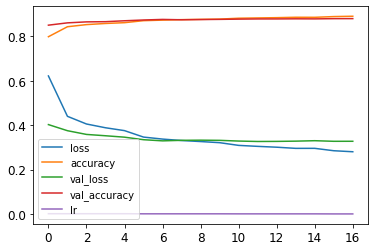

In [34]:
pd.DataFrame(history.history).plot()